# Random walks with infection


so this is a model I made after I found one  that I found googling [carole adams](https://www.liglab.fr/fr/membre/carole-adam)

- the world is modeled as in a [platform game](https://eloquentjavascript.net/16_game.html)
- I have another grid which contains a dictionary key to the transitions possible from a position

I wrapped this in a class called ```Grid``` because 

- it's easier to debug as the names and methods aren't global

The simulation is a loop which 

```for _ in simulation):
    make a blank grid
    for pt in pts:
        write the pt/agents in 
        update the position of the agent

    save the state of the sim
```





In [258]:
import numpy as np
import matplotlib.pyplot as plt

import random

from scipy import signal


import  matplotlib.animation

from matplotlib import animation

from IPython.display import HTML
def plot_images(img_list, fr=100):
    
  def init():
    img.set_data(img_list[0])
    return (img,)

  def animate(i):
    img.set_data(img_list[i])
    return (img,)

  fig = plt.figure()
  ax = fig.gca()
  plt.axis('off')
  img = ax.imshow(img_list[0])

  anim = animation.FuncAnimation(fig,
                                 animate, 
                                 init_func=init,
                                 frames=len(img_list), 
                                 interval=fr, 
                                 blit=True)
  return anim

# use like this
#HTML(plot_images(imgs).to_html5_video())

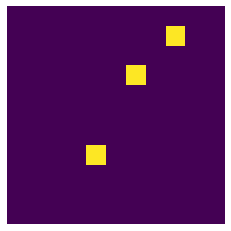

In [468]:
sz = 10

S = np.zeros((sz+1,sz+1),dtype=int)
S[:,0] = 1
S[0,:] += 2
S[sz,:] += 4
S[:,sz] += 7


diffs = [[1,0],[0,1],[-1,0],[0,-1]]

nogo = {0: [], 
        1: [3], 2: [2], 7: [1], 4: [0],
        5: [0,3], 9: [1,2],
        3: [2,3], 11:[0,1]
}

moves = {x:  [ y for k,y in enumerate(diffs) if k not in  nogo[x]] for x in nogo}

G = np.zeros((sz+1,sz+1))

pts = [ np.array([k,k],dtype=int) for k in range(2,sz,2)]
             
frames = []
for _ in range(200):
    G = np.zeros((sz+1,sz+1))
    for pt in pts:
        G[tuple(pt)] = 1
        #print(tuple(pts),S[tuple(pts)])
    
        pt += random.choice(moves[S[tuple(pt)]])
    
    frames.append(np.copy(G))

HTML(plot_images(frames, fr=100).to_html5_video()) 


In [607]:
! ../.g

[master 3d0315c] web
 1 file changed, 25209 insertions(+), 23902 deletions(-)
 rewrite PROG/random_blob.ipynb (68%)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.44 MiB | 193.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   949a575..3d0315c  master -> master


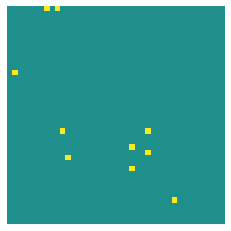

In [557]:
sz = 40
W =  np.zeros((sz+1,sz+1),dtype=int)
        #place the walls
W[:,0] = W[0,:] = W[sz,:] = W[:,sz] = 1
        

        # make a kernel
K = [0,1,0,2,0,8,0,4,0]
K = np.array(K).reshape(3,3)

        #these are the forbidden transitions for the states
forbidden = {0: [], 
                8: [3], 4: [2], 2: [1], 1: [0],
                9: [0,3], 6: [1,2],
                12: [2,3], 3:[0,1]
        }


        # calculate the states for the grid
X = signal.convolve2d( W, K)[2:-2,2:-2]

        #apparently these get cast to np.array when I add???
diffs = [[1,0],[0,1],[-1,0],[0,-1]]

allowed_moves = {}
for x in forbidden:
    allowed_moves[x] =  [ y for k,y in enumerate(diffs)
                                     if k not in  forbidden[x]] 
    
def get_move( pos):
    #globals is not good
    return random.choice(allowed_moves[X[pos]])
        
        
G = np.zeros_like(X) + 6
#initial configuration
pts = np.array([ np.array([k, k],dtype=int) for k in range(2, sz, 4)])
cols = np.array([ k%8 + 1 for k in range(2, sz, 4)])
             
frames = []
for _ in range(200):
    G = np.zeros((sz+1,sz+1)) + 5
    for pt,col in zip(pts,cols):
        pos = tuple(pt[:2])
        G[pos] = col
        pt += get_move(pos)
    
    # this is a bit of a hack to reduce computations
    Z = scipy.spatial.distance_matrix(pts[cols==3], pts[cols==7], p=np.infty)
    uninfected = np.where(cols==3)[0]
    uninfected_collisions = uninfected[np.any(Z < .5, axis = 1)]
    cols[uninfected_collisions ] = 7
    
    frames.append(np.copy(G))

HTML(plot_images(frames, fr=100).to_html5_video()) 


In [591]:

class Grid():
    
    def __init__(self, sz = 40):
        self.sz = sz
        W =  np.zeros((sz+1,sz+1),dtype=int)
        #place the walls
        W[:,0] = W[0,:] = W[sz,:] = W[:,sz] = 1
        
        #expose this so that you can add extra walls
        #some would say I should not expose W but...
        self.W = W
        self.mk_moves()
        
        
    def mk_moves(self):
        # you can rewrite this without using the convolution
        
            # mke a kernel
            K = [0,1,0,2,0,8,0,4,0]
            K = np.array(K).reshape(3,3)

            #these are the forbidden transitions for the states
            forbidden = {0: [], 
                    8: [3], 4: [2], 2: [1], 1: [0],
                    9: [0,3], 6: [1,2],
                    12: [2,3], 3:[0,1]
            }


            # calculate the states for the grid
            self.X = signal.convolve2d(self.W, K)[2:-2,2:-2]

            #apparently these get cast to np.array when I add???
            diffs = [[1,0],[0,1],[-1,0],[0,-1]]

            allowed_moves = {}
            for x in forbidden:
                allowed_moves[x] =  [ y for k,y in enumerate(diffs)
                                         if k not in  forbidden[x]] 
            #expose to the user
            self.allowed_moves = allowed_moves
    
    def get_move(self, pos):
        return random.choice(self.allowed_moves[self.X[pos]])
        
    
GG = Grid()      
            
G = np.zeros_like(GG.X) + 6
#initial configuration
sz = G.shape[0]
pts = np.array([ np.array([k, k],dtype=int) for k in range(2, sz, 4)])
cols = np.array([ k%8 + 1 for k in range(2, sz, 4)])
             
frames = []
for _ in range(200):
    G = np.zeros_like(GG.X) + 5
    for pt,col in zip(pts,cols):
        pos = tuple(pt[:2])
        G[pos] = col
        pt += GG.get_move(pos)
    
    # this is a bit of a hack to reduce computations
    Z = scipy.spatial.distance_matrix(pts[cols==3], pts[cols==7], p=np.infty)
    uninfected = np.where(cols==3)[0]
    uninfected_collisions = uninfected[np.any(Z < .5, axis = 1)]
    cols[uninfected_collisions ] = 7
    
    frames.append(np.copy(G))



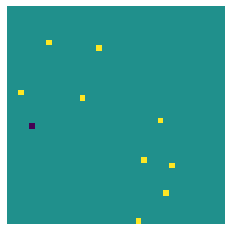

In [592]:
raw_anim = plot_images(frames, fr=100)
HTML(raw_anim.to_html5_video()) 

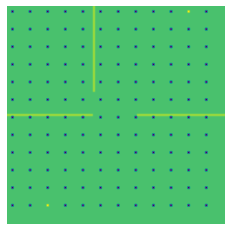

In [619]:
def clip(x):
    # don't look outside the box
    # sz is global
    if x < 0 : return 0
    if x > sz :return sz
    return x

sz = 100
world  = Grid(sz=sz)
world.W[50] = 1
world.W[50,40:60] = 0
world.W[:40,40] = 1
world.mk_moves()

sz -= 2
            
#initial configuration evenly spaced

pp = []
for j in range(2, sz,8):
    for k in range(2, sz,8):
        pp.append( np.array([j,k],dtype=int) )
        
pts = np.array(pp)
#choose who is infected
cols = np.zeros(len(pp))
cols[10] = cols[-10] = 7
      
frames = []
dd = []
for k in range(1000):
    G = np.zeros_like( world.X) + 5
    for pt,color in zip(pts,cols):
        pos = tuple(pt)
        G[pos] = color
        pt += world.get_move(pos)
    
    #count infected
    dd.append(len(cols[cols>5]))
    # I have to recalculate this every time  
    #maybe I should just delete the infected ???
    for _ in np.where(cols == 0)[0]:
        x, y = pts[_]
        neighbors = G[clip(x-1):clip(x+2), clip(y-1):clip(y+2) ]
        if np.max(neighbors) > 5:
            cols[_] = 7
 
    frames.append(G + world.W[1:-1,1:-1])

if True:
    raw_anim = plot_images(frames, fr=100)
    #raw_anim.save('random_epi.gif', writer='imagemagick', fps=10)
else:
    plt.plot(dd);  # symmetric


In [547]:
raw_anim.save('random_epi.gif', writer='imagemagick', fps=10)

In [620]:
HTML(raw_anim.to_html5_video()) 

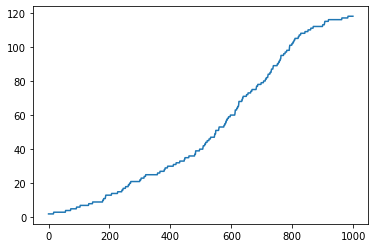

In [621]:
plt.plot(dd);  # symmetric

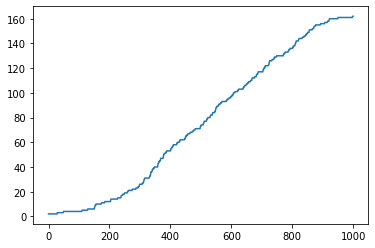

In [545]:
plt.plot(dd);  # symmetric

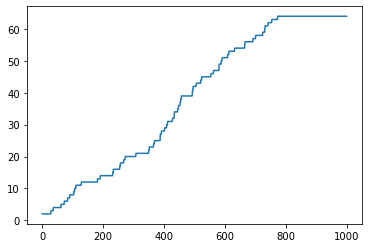

In [467]:
plt.plot(dd);  # symmetric

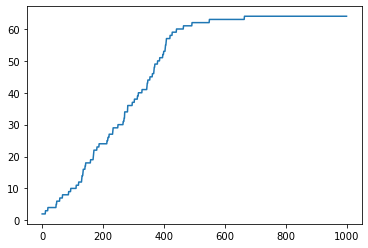

In [464]:
plt.plot(dd);  # symmetric

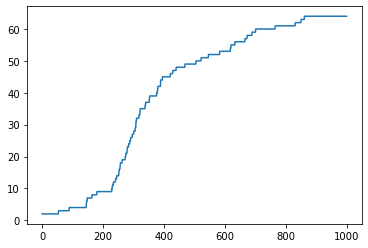

In [461]:
plt.plot(dd);

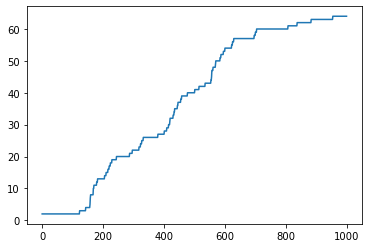

In [454]:
plt.plot(dd);

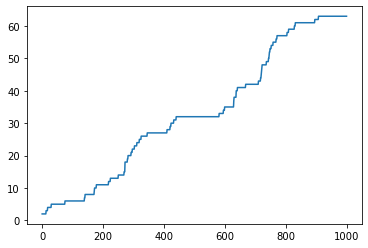

In [452]:
plt.plot(dd);